In [1]:
from __future__ import print_function
import torch
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
%matplotlib inline
from utils import *
import torch
import random
from PIL import Image,ImageFilter
import pickle
from torchvision.transforms import functional as FT
from torch.autograd import Variable
from torch.utils.data import Dataset

In [2]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10
batch_size = 500


mean_id = (0.4914, 0.4822, 0.4465)  #  mean along channels
std_id = (0.2023, 0.1994, 0.2010)  #  std along channels
print((mean_id, std_id))

# Define normalization transformation
normalize_transform_id = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])


train_dataset_id = datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = normalize_transform_id)
test_dataset_id = datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = normalize_transform_id)



train_loader_id = torch.utils.data.DataLoader(train_dataset_id
                                              , batch_size = batch_size
                                              , shuffle = True)
test_loader_id = torch.utils.data.DataLoader(test_dataset_id
                                             , batch_size = batch_size
                                             , shuffle = True)
n_total_step = len(train_loader_id)
print(n_total_step)

((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.201))
Files already downloaded and verified
Files already downloaded and verified
100


In [3]:
classifier = nn.Linear(512, num_classes)
neta = resnet9(classifier, mod=True)
neta = load_net('2512cfv1.t7', neta).to(device)
criterion_sm = CE_Loss(neta.classifier, num_classes).to(device)
sgd = optim.SGD([{'params': neta.parameters()}, ],
                lr=0.1, momentum=0.9, weight_decay=5e-4)
optimizer = Optimizer(sgd, train_loader_id, device)
(acc, conf) = optimizer.test_acc(neta, criterion_sm, test_loader_id)

2512cfv1.t7 ACC:	 tensor(90.6600)
Loss: 0.373 | Acc: 90.660% (9066/10000) | Conf 95.88


In [16]:

def entropy_prob(probs):
    p = probs
    eps = 1e-12
    logp = torch.log(p + eps)
    plogp = p * logp
    entropy = -torch.sum(plogp, dim=0)
    return entropy

def logsumexp(logits):
    return torch.logsumexp(logits, dim=0, keepdim=False)

def fit_DDU(net, train_loader, test_loader):
    embeddings, labels, confs = gather_embeddings(net, 512, test_loader, device=device, storage_device='cuda')
    DDU = Gauss_DDU(512, 10, gamma=-0.001)
    DDU.fit(embeddings,labels)
    mahal_dist = DDU.forward(embeddings)
    all_min_dist = []
    for dist in mahal_dist:
        min_dist = min(dist)
        all_min_dist.append(min_dist)
    percentile_low = np.percentile(all_min_dist, 5)
    percentile_high = np.percentile(all_min_dist, 95)
    DDU.percentile = (percentile_low, percentile_high)
    print(DDU.percentile)
    return DDU

def predict_DDU(net, test_loader, DDU):
    predictions = []
    net.eval()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            embeddings = net.embed(inputs).to('cuda')
            Y_pred = net.conf(inputs)
            confBatch, predicted = Y_pred.max(1)
            mahal_dist = DDU.forward(embeddings)
            all_min_dist = []
            for dist in mahal_dist:
                min_dist = min(dist)
                all_min_dist.append(min_dist)
            id_ood = (torch.tensor(all_min_dist)>DDU.percentile[1].to('cpu'))

            for i in range(len(predicted)):
                if id_ood[i]==True:
                    prediction = (1,  int(predicted[i]), float(confBatch[i]), targets[i], all_min_dist[i])
                else:
                    prediction = (0, int(predicted[i]), float(confBatch[i]), targets[i], all_min_dist[i])
                predictions.append(prediction)
            print(len(predictions))
    return predictions

def predict_DDU_grad(net, test_loader, DDU):
    predictions = []
    net.eval()
    for batch_idx, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            inputs, targets = inputs.to('cuda'), targets.to('cuda')
            embeddings = net.embed(inputs).to('cuda')
            Y_pred = net.conf(inputs)
            confBatch, predicted = Y_pred.max(1)
            mahal_dist = DDU.forward(embeddings)
            all_min_dist = []
            for dist in mahal_dist:
                min_dist = min(dist)
                all_min_dist.append(min_dist)
            id_ood = (torch.tensor(all_min_dist)>DDU.percentile[1].to('cpu'))

            for i in range(len(predicted)):
                if id_ood[i]==True:
                    prediction = (1,  int(predicted[i]), float(confBatch[i]), targets[i], all_min_dist[i])
                else:
                    prediction = (0, int(predicted[i]), float(confBatch[i]), targets[i], all_min_dist[i])
                predictions.append(prediction)
            print(len(predictions))
    return predictions

def calc_FPR95(preds):
    id=0
    acc=0
    acc2=0
    for i in range(len(preds)):
        if preds[i][0] == 0:
            id+=1
        if preds[i][1]==preds[i][3] and preds[i][0] == 0:
            acc+=1
        if preds[i][1]==preds[i][3]:
            acc2+=1
    print(f'percentage ID: {id/10000}, percentage accurate total: {acc2/10000}, percentage accurate and ID: {acc/10000},'
          f' percentage accurate of ID: {acc/id}')

def plot_hist(preds_id, preds_ood, threshold):
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(float(preds_id[i][4].cpu()))
        ood_data.append(float(preds_ood[i][4].cpu()))
    print(len(id_data), len(ood_data))
    bin_edges = np.linspace(min(min(id_data), min(ood_data)), max(max(id_data), max(ood_data)), 75)  # 30 bins

    plt.hist(id_data, bins=bin_edges, alpha=0.5, label='ID data', color='blue', density=True)
    plt.hist(ood_data, bins=bin_edges, alpha=0.5, label='OOD data', color='orange', density=True)
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({round(float(threshold),4)})')

    # Adding labels and title
    plt.xlabel('OOD detection method score')
    plt.ylabel('Frequency')
    plt.yticks([])
    plt.legend()

    # Displaying the plot
    plt.show()

from sklearn.metrics import roc_auc_score,roc_curve, auc
def calc_auroc(preds_id, preds_ood):
    id_labels = [1]*10000
    ood_labels = [0]*10000
    id_data=[]
    ood_data=[]
    for i in range(len(preds_id)):
        id_data.append(-1*preds_id[i][4].cpu())
        ood_data.append(-1*preds_ood[i][4].cpu())
    data = id_data+ ood_data
    labels = id_labels+ ood_labels
    auroc = roc_auc_score(labels, data)
    fpr, tpr, thresholds = roc_curve(labels, data)
    print(f'AUROC: {auroc}')
    roc_auc = auc(fpr, tpr)
    idx = next(i for i, v in enumerate(tpr) if v >= 0.95)
    fpr_at_tpr_95 = fpr[idx]

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUROC = {roc_auc:.2f}')
    #plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    #plt.ylim(0.5, 1)
    plt.axvline(x=fpr_at_tpr_95, color='red', linestyle='--', label='TPR = 0.95')
    plt.legend(loc='lower right')
    plt.show()



In [5]:
DDU = fit_DDU(neta, train_loader_id, test_loader_id)

(tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.6492, device='cuda:0', grad_fn=<AddBackward0>))


In [8]:
preds_id= predict_DDU(neta, test_loader_id, DDU)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [9]:
threshold= DDU.percentile[1].to('cpu')
threshold

tensor(0.6492, grad_fn=<ToCopyBackward0>)

In [10]:
calc_FPR95(preds_id)

percentage ID: 0.95, percentage accurate total: 0.9066, percentage accurate and ID: 0.8798, percentage accurate of ID: 0.9261052631578948


In [11]:
# Define normalization transformation
normalize_transform_svhn = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id)])

dataset_svhn = datasets.SVHN(
    root= './data', split = 'test',
    download =True, transform=normalize_transform_svhn)

class_indices = {i: [] for i in range(10)}
for idx, (_, label) in enumerate(dataset_svhn):
    class_indices[label].append(idx)

# Select 1,000 random indices for each class
selected_indices = []
for label, indices in class_indices.items():
    selected_indices.extend(indices[:1000])

dataset_svhn = torch.utils.data.Subset(dataset_svhn, selected_indices)

loader_svhn = torch.utils.data.DataLoader(dataset_svhn
                                          , batch_size = batch_size
                                          , shuffle = True)

Using downloaded and verified file: ./data\test_32x32.mat


In [12]:
preds_svhn = predict_DDU(neta, loader_svhn, DDU)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [13]:
calc_FPR95(preds_svhn)

percentage ID: 0.7947, percentage accurate total: 0.1085, percentage accurate and ID: 0.0848, percentage accurate of ID: 0.10670693343400026


10000 10000


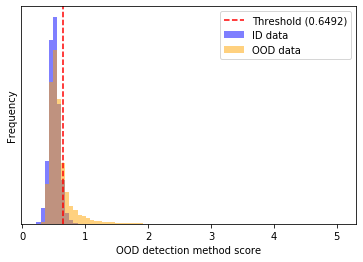

In [14]:
plot_hist(preds_id, preds_svhn, threshold)

AUROC: 0.624149685


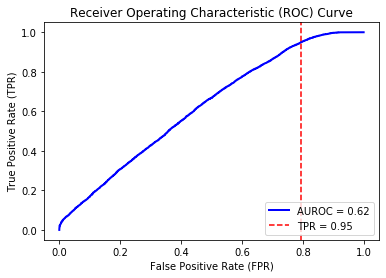

In [15]:
calc_auroc(preds_id, preds_svhn)

In [17]:
path_data = 'C:\\Users\\20203666\\Documents\\BEP\\code\\Representation_Learning\\data\\imagenet_test\\imagenet_data.pkl'
path_labels = 'C:\\Users\\20203666\\Documents\\BEP\\code\\Representation_Learning\\data\\imagenet_test\\imagenet_labels.pkl'

with open(path_data, 'rb') as file:
    # Load the data from the pickle file
    imagenet_data = pickle.load(file)

with open(path_labels, 'rb') as file:
    # Load the data from the pickle file
    imagenet_labels = pickle.load(file)


class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image and label to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        #label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label


# Define normalization transformation
normalize_transform_domain_shift = transforms.Compose([transforms.Normalize(mean_id, std_id)])

dataset_domain_shift = CustomDataset(imagenet_data, imagenet_labels, transform=normalize_transform_domain_shift)

loader_domain_shift = torch.utils.data.DataLoader(dataset_domain_shift
                                                  , batch_size=batch_size
                                                  , shuffle=False)

In [18]:
preds_domain_shift = predict_DDU(neta, loader_domain_shift, DDU)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [19]:
calc_FPR95(preds_domain_shift)

percentage ID: 0.0869, percentage accurate total: 0.7385, percentage accurate and ID: 0.0668, percentage accurate of ID: 0.7686996547756041


10000 10000


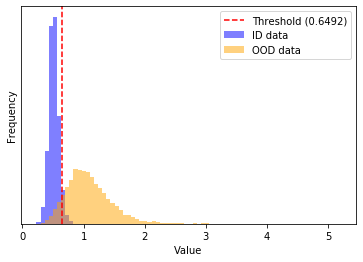

In [20]:
plot_hist(preds_id, preds_domain_shift, threshold)

AUROC: 0.9696111599999999


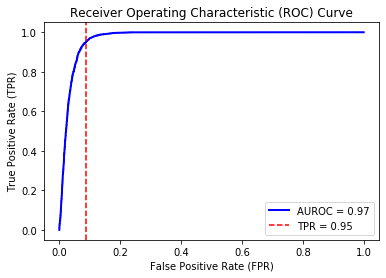

In [44]:
calc_auroc(preds_id, preds_domain_shift)

In [21]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        # Add Gaussian noise to the tensor
        noise = torch.randn(tensor.size()) * self.std + self.mean
        noisy_tensor = tensor + noise

        # Clip pixel values to maintain range between 0 and 1
        noisy_tensor = torch.clamp(noisy_tensor, 0., 1.)
        return noisy_tensor

noise_level = 0.075

normalize_transform_noise = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=noise_level),
    transforms.Normalize(mean_id, std_id)])


dataset_noise = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_noise)

loader_noise = torch.utils.data.DataLoader(dataset_noise
                                           , batch_size=batch_size
                                           , shuffle=False)
preds_noise = predict_DDU(neta, loader_noise, DDU)

Files already downloaded and verified
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [22]:
calc_FPR95(preds_noise)

percentage ID: 0.1376, percentage accurate total: 0.4386, percentage accurate and ID: 0.0837, percentage accurate of ID: 0.6082848837209303


10000 10000


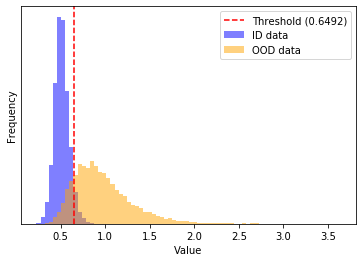

AUROC: 0.95855577


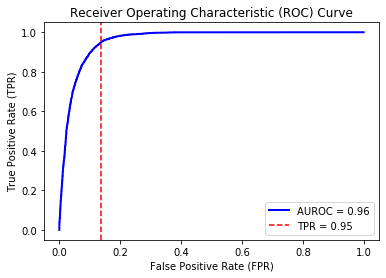

In [23]:
plot_hist(preds_id, preds_noise, threshold) #0.025
calc_auroc(preds_id, preds_noise)

In [24]:
class AddBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        pil_img = transforms.ToPILImage()(img)  # Convert Tensor to PIL Image
        blurred_img = pil_img.filter(ImageFilter.GaussianBlur(radius=self.radius))  # Apply Gaussian blur
        return transforms.ToTensor()(blurred_img)

blur_level = 1


normalize_transform_blur = transforms.Compose([
    transforms.ToTensor(),
    AddBlur(radius=blur_level),
    transforms.Normalize(mean_id, std_id)])


dataset_blur = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_blur)

loader_blur = torch.utils.data.DataLoader(dataset_blur
                                          , batch_size=batch_size
                                          , shuffle=False)
preds_blur = predict_DDU(neta, loader_blur, DDU)

Files already downloaded and verified
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [25]:
calc_FPR95(preds_blur)

percentage ID: 0.6629, percentage accurate total: 0.4297, percentage accurate and ID: 0.2704, percentage accurate of ID: 0.4079046613365515


10000 10000


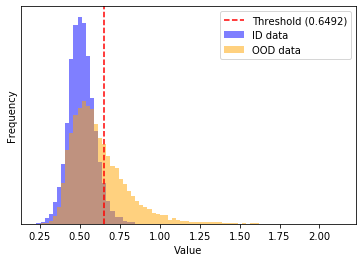

AUROC: 0.6934741200000001


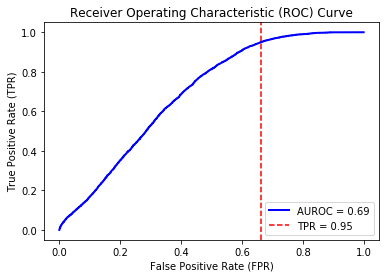

In [26]:
plot_hist(preds_id, preds_blur, threshold) #0.075
calc_auroc(preds_id, preds_blur)

In [27]:
# Custom transformation to add brightness
class AddBrightness(object):
    def __init__(self, brightness=1, contrast=1, saturation=1, hue=0, randomhue=False):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.randomhue = randomhue
    def __call__(self, img):

        # Apply color shift deterministically
        img = FT.adjust_brightness(img, self.brightness)
        img = FT.adjust_contrast(img, self.contrast)
        img = FT.adjust_saturation(img, self.saturation)
        img = FT.adjust_hue(img, self.hue)
        if self.randomhue==True:
            random_number = 0  # Initialize with 5 to start the loop
            while random_number == 0 :
                random_number = random.randint(1, 10)
                random_number = (random_number-5)/10
            img = FT.adjust_hue(img, random_number)
        return img
normalize_transform_bright = transforms.Compose([
    transforms.ToTensor(),
    AddBrightness(brightness=1.75),
    transforms.Normalize(mean_id, std_id)])


dataset_bright = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_bright)

loader_bright = torch.utils.data.DataLoader(dataset_bright
                                           , batch_size=batch_size
                                           , shuffle=False)
preds_bright= predict_DDU(neta, loader_bright, DDU)



Files already downloaded and verified
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [28]:
calc_FPR95(preds_bright)

percentage ID: 0.1087, percentage accurate total: 0.811, percentage accurate and ID: 0.0979, percentage accurate of ID: 0.9006439742410304


10000 10000


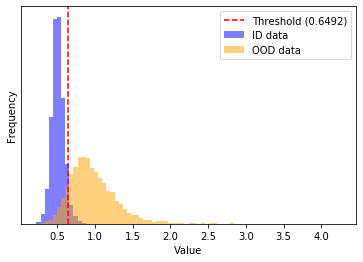

AUROC: 0.9647894650000001


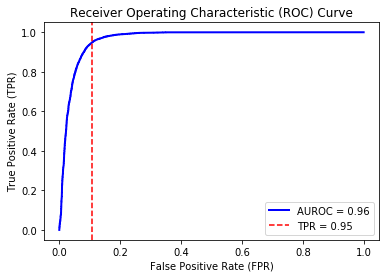

In [29]:
plot_hist(preds_id, preds_bright, threshold) #0.075
calc_auroc(preds_id, preds_bright)

In [17]:
# FGSM attack to generate adversarial examples
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    return perturbed_image

# Custom transformation to apply FGSM attack
class AdversarialAttack(object):
    def __init__(self, model, epsilon=0.1):
        self.epsilon = epsilon
        self.model = model

    def __call__(self, img):
        criterion = torch.nn.CrossEntropyLoss().cuda()
        input = Variable(img.cuda(), requires_grad=True)
        output = self.model(input.unsqueeze(0))  # Assuming 'model' is your trained model
        _, pred = output.max(1)
        loss = criterion(output, pred)
        loss.backward()
        data_grad = input.grad.data
        perturbed_img = fgsm_attack(input, self.epsilon, data_grad)
        perturbed_img = perturbed_img.squeeze(0)
        perturbed_img = perturbed_img.to('cpu')
        perturbed_img = perturbed_img.detach()
        return perturbed_img

attack_level = 0.15

normalize_transform_adversarial = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_id, std_id),
    AdversarialAttack(model=neta, epsilon=attack_level),
    ])

dataset_adversarial = datasets.CIFAR10(root='./data', train=False, download=True, transform=normalize_transform_adversarial)

loader_adversarial = torch.utils.data.DataLoader(dataset_adversarial
                                                 , batch_size=batch_size
                                                 , shuffle=False)


Files already downloaded and verified


In [18]:
preds_adversarial = predict_DDU_grad(neta, loader_adversarial, DDU)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000


In [19]:
calc_FPR95(preds_adversarial)

percentage ID: 0.0595, percentage accurate total: 0.0849, percentage accurate and ID: 0.0067, percentage accurate of ID: 0.11260504201680673


10000 10000


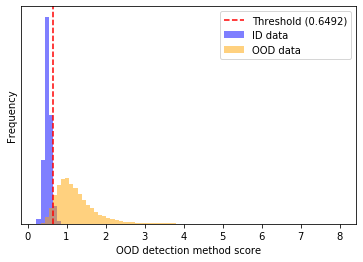

AUROC: 0.9814326400000001


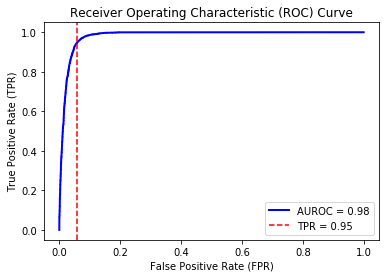

In [20]:
plot_hist(preds_id, preds_adversarial, threshold) #0.075
calc_auroc(preds_id, preds_adversarial)